Import trick

In [18]:
import sys
sys.path.insert(0, '..')

In [19]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

In [20]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname_095 = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'
fname_108 = ddir + 'HST/N43C03020/n43c03020_mos.fits'
fname_187 = ddir + 'HST/N43C03010/n43c03010_mos.fits'
fname_190 = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'


wid = 64

exposure_095 = exposure_from_file(fname_095, SinglePointFit(), wid)
exposure_108 = exposure_from_file(fname_108, SinglePointFit(), wid)
exposure_187 = exposure_from_file(fname_187, SinglePointFit(), wid)
exposure_190 = exposure_from_file(fname_190, SinglePointFit(), wid)

exposures_s = [exposure_095, exposure_190,exposure_108, exposure_187]

exposure_095 = exposure_from_file(fname_095, BinaryFit(), wid)
exposure_108 = exposure_from_file(fname_108, BinaryFit(), wid)
exposure_187 = exposure_from_file(fname_187, BinaryFit(), wid)
exposure_190 = exposure_from_file(fname_190, BinaryFit(), wid)

exposures_b = [exposure_095, exposure_190, exposure_108, exposure_187]


models

In [21]:
oversample = 3

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

params_s = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

params_b = {
    "fluxes": {},
    "positions": {},
    "contrast": {},
    "separation": dlu.arcsec2rad(0.042),
    "position_angle": 1.8607855,
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([0.05, 0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures_s:
    params_s["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_s["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    params_s["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_s["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.05,-0.05])
    params_s["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

for exp in exposures_b:
    params_b["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_b["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)/2
    params_b["contrast"][exp.fit.get_key(exp, "contrast")] = 0.3
    params_b["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_b["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.05,-0.05])
    params_b["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

def set_array(pytree):
    dtype = np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

point_model = set_array(NICMOSModel(exposures_s, params_s, optics, detector))
binary_model = set_array(NICMOSModel(exposures_b, params_b, optics, detector))

In [22]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 3e-2

things_single = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "cold_mask_shift": opt(g*100, 100),
    "cold_mask_rot": opt(g*100, 100),
    "aberrations": opt(g*0.06,50),
    "outer_radius": opt(g*100, 130),
    "secondary_radius": opt(g*100,130),
    "spider_width": opt(g*100,130),
}

g = 2e-2

things_binary = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "separation": opt(g*5, 20),
    "contrast": opt(g*8, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask_shift": opt(g*100,130),
    "cold_mask_rot": opt(g*100,100),
    "aberrations": opt(g*1,50),
    "outer_radius": opt(g*50, 100),
    "secondary_radius": opt(g*50,100),
    "spider_width": opt(g*10,100),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [23]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(model,exposures):
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(model,exposures):
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

In [24]:
print(loss_fn_s(point_model, exposures_s))
#print(loss_fn_b(binary_model, exposures_b))

(Array(1.310629e+08, dtype=float32), NICMOSModel(
  params={
    'aberrations':
    {
      'N43C03010':
      f32[8],
      'N43C03020':
      f32[8],
      'N43CA5010':
      f32[8],
      'N43CA5020':
      f32[8]
    },
    'cold_mask_rot':
    {
      'N43C03010':
      f32[],
      'N43C03020':
      f32[],
      'N43CA5010':
      f32[],
      'N43CA5020':
      f32[]
    },
    'cold_mask_shift':
    {
      'N43C03010':
      f32[2],
      'N43C03020':
      f32[2],
      'N43CA5010':
      f32[2],
      'N43CA5020':
      f32[2]
    },
    'fluxes':
    {
      'N43C03010':
      f32[],
      'N43C03020':
      f32[],
      'N43CA5010':
      f32[],
      'N43CA5020':
      f32[]
    },
    'outer_radius':
    f32[],
    'positions':
    {
      'N43C03010':
      f32[2],
      'N43C03020':
      f32[2],
      'N43CA5010':
      f32[2],
      'N43CA5020':
      f32[2]
    },
    'secondary_radius':
    f32[],
    'spider_width':
    f32[]
  },
  filters={'F095N': None, 'F108N

In [25]:
rc = False
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc)
lrs_s = calc_lrs(point_model, exposures_s, fishers_s, paths_s)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc)
lrs_b = calc_lrs(binary_model, exposures_b, fishers_b, paths_b)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[30.453743]]
[[ 3.9201110e+21 -1.4288641e+20]
 [-1.4288634e+20  4.2445813e+21]]
[[-8.3616091e+11  6.2965567e+11]
 [ 6.2965560e+11 -8.1288148e+11]]
[[-8.518749e+11]]
[[-2.02957630e+21  1.72064070e+20  5.29780133e+20  1.04233836e+21
   7.37624106e+20 -9.67551409e+19 -2.09878791e+20 -1.64491021e+20]
 [ 1.72061220e+20 -3.40102696e+21 -2.04152956e+20  8.88754072e+20
   5.97939052e+20  5.33847904e+20 -5.24962196e+20  1.53305170e+20]
 [ 5.29777353e+20 -2.04156000e+20 -3.44953101e+21 -1.20096942e+21
   5.07730333e+20  4.88007628e+20  3.99051965e+20  1.25551605e+20]
 [ 1.04231859e+21  8.88758365e+20 -1.20096605e+21 -3.43777317e+20
  -2.38719843e+20  5.96540685e+20  2.83601995e+20  7.04617294e+20]
 [ 7.37616435e+20  5.97914705e+20  5.07731600e+20 -2.38722006e+20
   1.48533202e+20 -2.02668580e+20 -3.47070996e+20  5.11761653e+20]
 [-9.67539446e+19  5.33848432e+20  4.88009176e+20  5.96543499e+20
  -2.02671237e+20  2.52562149e+20 -2.47121624e+20 -5.92116874e+19]
 [-2.09878316e+20 -5.24950550e+20  3

  0%|          | 0/8 [00:00<?, ?it/s]

[[4.474164]]
[[ 5.3143551e+21 -6.2915920e+19]
 [-6.2916021e+19  5.3490153e+21]]
[[ 2.7680509e+11 -2.0810821e+11]
 [-2.0810822e+11  2.6918275e+11]]
[[2.8472102e+11]]
[[ 5.87832728e+20  2.83523587e+20  4.14092297e+18  5.94689775e+20
   5.18813340e+20  2.31992626e+20 -7.56790423e+19  3.89284537e+20]
 [ 2.83524660e+20  1.62842369e+20 -1.37864297e+20  4.87334093e+20
   2.98061558e+20  1.51893890e+20 -2.36342289e+19  2.41950436e+20]
 [ 4.14471821e+18 -1.37868994e+20  4.61001124e+20 -5.66576794e+20
   2.29864710e+20 -1.01494960e+20 -1.38081103e+20 -5.52083040e+19]
 [ 5.94696531e+20  4.87335677e+20 -5.66581332e+20  3.22411515e+21
  -6.96862608e+18  6.47637611e+20 -2.03047846e+19 -9.97848056e+19]
 [ 5.18805916e+20  2.98063529e+20  2.29864605e+20 -6.96823081e+18
   3.43401076e+21 -1.74300982e+19 -5.82232889e+20 -1.23460246e+20]
 [ 2.31996971e+20  1.51895825e+20 -1.01504873e+20  6.47640778e+20
  -1.74287370e+19  3.62692132e+21 -4.97549454e+20  1.28515317e+20]
 [-7.56815932e+19 -2.36243245e+19 -1.

  0%|          | 0/8 [00:00<?, ?it/s]

[[15.940705]]
[[5.4321366e+21 2.9594624e+20]
 [2.9594620e+20 6.2183716e+21]]
[[-3.7030828e+11  2.7890113e+11]
 [ 2.7890113e+11 -3.5996290e+11]]
[[-3.765681e+11]]
[[-3.10827082e+20  3.44093026e+20 -1.15936651e+19  9.26390092e+20
   7.48640544e+20  2.16401129e+20 -1.51306557e+20  2.98030877e+20]
 [ 3.44089472e+20 -1.08287090e+21 -1.55384848e+20  7.65742119e+20
   4.61793687e+20  3.25436020e+20 -2.44403684e+20  2.69151967e+20]
 [-1.15834463e+19 -1.55378163e+20 -1.00583211e+21 -8.72330078e+20
   3.28445621e+20  8.24241503e+19  5.89558399e+19 -6.17204563e+19]
 [ 9.26404587e+20  7.65746482e+20 -8.72340915e+20  2.82477985e+21
   3.26026942e+20  1.01440070e+21 -2.37261345e+20  8.31318576e+19]
 [ 7.48637166e+20  4.61802519e+20  3.28446500e+20  3.26030073e+20
   2.94125729e+21  4.20295128e+20 -8.79856578e+20 -1.34620916e+19]
 [ 2.16405949e+20  3.25436689e+20  8.24292872e+19  1.01441407e+21
   4.20293158e+20  3.39916697e+21 -6.24743774e+20 -4.22308342e+19]
 [-1.51307929e+20 -2.44401714e+20  5.895

  0%|          | 0/8 [00:00<?, ?it/s]

[[4.680813]]
[[5.0978710e+21 3.3051742e+20]
 [3.3051756e+20 6.0383217e+21]]
[[-6.7445287e+11  5.0812935e+11]
 [ 5.0812935e+11 -6.5561946e+11]]
[[-6.84965e+11]]
[[-1.11928120e+20  4.16456724e+20 -3.85383118e+20  7.69067253e+20
   7.05203396e+20  2.56122297e+20 -4.72151360e+19  2.99912819e+20]
 [ 4.16458589e+20 -1.06838366e+21 -7.22066438e+19  7.45903551e+20
   4.16436282e+20  3.14834898e+20 -2.22934110e+20  2.88948472e+20]
 [-3.85369854e+20 -7.22048538e+19 -1.00366940e+21 -7.80906372e+20
   3.88173274e+20  1.77625345e+19  6.47799618e+19 -1.55427685e+20]
 [ 7.69066479e+20  7.45906507e+20 -7.80907850e+20  3.06032374e+21
   2.10034464e+20  7.73531446e+20 -9.34616198e+19 -1.66081077e+17]
 [ 7.05202551e+20  4.16431075e+20  3.88179502e+20  2.10036504e+20
   2.85667265e+21  1.19928527e+20 -7.73816932e+20 -7.53216098e+18]
 [ 2.56126396e+20  3.14836693e+20  1.77435459e+19  7.73528913e+20
   1.19931500e+20  3.40686165e+21 -5.02441946e+20  7.92425067e+19]
 [-4.72141816e+19 -2.22927689e+20  6.47814

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[30.453743]]
[[ 3.9201110e+21 -1.4288641e+20]
 [-1.4288634e+20  4.2445813e+21]]
[[8.823964e+20]]
[[67626168.]]
[[21600522.]]
[[-8.3616091e+11  6.2965567e+11]
 [ 6.2965560e+11 -8.1288148e+11]]
[[-8.518749e+11]]
[[-2.02957630e+21  1.72064070e+20  5.29780133e+20  1.04233836e+21
   7.37624106e+20 -9.67551409e+19 -2.09878791e+20 -1.64491021e+20]
 [ 1.72061220e+20 -3.40102696e+21 -2.04152956e+20  8.88754072e+20
   5.97939052e+20  5.33847904e+20 -5.24962196e+20  1.53305170e+20]
 [ 5.29777353e+20 -2.04156000e+20 -3.44953101e+21 -1.20096942e+21
   5.07730333e+20  4.88007628e+20  3.99051965e+20  1.25551605e+20]
 [ 1.04231859e+21  8.88758365e+20 -1.20096605e+21 -3.43777317e+20
  -2.38719843e+20  5.96540685e+20  2.83601995e+20  7.04617294e+20]
 [ 7.37616435e+20  5.97914705e+20  5.07731600e+20 -2.38722006e+20
   1.48533202e+20 -2.02668580e+20 -3.47070996e+20  5.11761653e+20]
 [-9.67539446e+19  5.33848432e+20  4.88009176e+20  5.96543499e+20
  -2.02671237e+20  2.52562149e+20 -2.47121624e+20 -5.92116

  0%|          | 0/11 [00:00<?, ?it/s]

[[4.474164]]
[[ 5.3143551e+21 -6.2915920e+19]
 [-6.2916021e+19  5.3490153e+21]]
[[5.9393296e+20]]
[[63456724.]]
[[20970138.]]
[[ 2.7680509e+11 -2.0810821e+11]
 [-2.0810822e+11  2.6918275e+11]]
[[2.8472102e+11]]
[[ 5.87832728e+20  2.83523587e+20  4.14092297e+18  5.94689775e+20
   5.18813340e+20  2.31992626e+20 -7.56790423e+19  3.89284537e+20]
 [ 2.83524660e+20  1.62842369e+20 -1.37864297e+20  4.87334093e+20
   2.98061558e+20  1.51893890e+20 -2.36342289e+19  2.41950436e+20]
 [ 4.14471821e+18 -1.37868994e+20  4.61001124e+20 -5.66576794e+20
   2.29864710e+20 -1.01494960e+20 -1.38081103e+20 -5.52083040e+19]
 [ 5.94696531e+20  4.87335677e+20 -5.66581332e+20  3.22411515e+21
  -6.96862608e+18  6.47637611e+20 -2.03047846e+19 -9.97848056e+19]
 [ 5.18805916e+20  2.98063529e+20  2.29864605e+20 -6.96823081e+18
   3.43401076e+21 -1.74300982e+19 -5.82232889e+20 -1.23460246e+20]
 [ 2.31996971e+20  1.51895825e+20 -1.01504873e+20  6.47640778e+20
  -1.74287370e+19  3.62692132e+21 -4.97549454e+20  1.28515

  0%|          | 0/11 [00:00<?, ?it/s]

[[15.940705]]
[[5.4321366e+21 2.9594624e+20]
 [2.9594620e+20 6.2183716e+21]]
[[9.935796e+20]]
[[53642364.]]
[[40896056.]]
[[-3.7030828e+11  2.7890113e+11]
 [ 2.7890113e+11 -3.5996290e+11]]
[[-3.765681e+11]]
[[-3.10827082e+20  3.44093026e+20 -1.15936651e+19  9.26390092e+20
   7.48640544e+20  2.16401129e+20 -1.51306557e+20  2.98030877e+20]
 [ 3.44089472e+20 -1.08287090e+21 -1.55384848e+20  7.65742119e+20
   4.61793687e+20  3.25436020e+20 -2.44403684e+20  2.69151967e+20]
 [-1.15834463e+19 -1.55378163e+20 -1.00583211e+21 -8.72330078e+20
   3.28445621e+20  8.24241503e+19  5.89558399e+19 -6.17204563e+19]
 [ 9.26404587e+20  7.65746482e+20 -8.72340915e+20  2.82477985e+21
   3.26026942e+20  1.01440070e+21 -2.37261345e+20  8.31318576e+19]
 [ 7.48637166e+20  4.61802519e+20  3.28446500e+20  3.26030073e+20
   2.94125729e+21  4.20295128e+20 -8.79856578e+20 -1.34620916e+19]
 [ 2.16405949e+20  3.25436689e+20  8.24292872e+19  1.01441407e+21
   4.20293158e+20  3.39916697e+21 -6.24743774e+20 -4.22308342e

  0%|          | 0/11 [00:00<?, ?it/s]

[[4.680813]]
[[5.0978710e+21 3.3051742e+20]
 [3.3051756e+20 6.0383217e+21]]
[[4.4975958e+20]]
[[2.2260155e+08]]
[[-18897600.]]
[[-6.7445287e+11  5.0812935e+11]
 [ 5.0812935e+11 -6.5561946e+11]]
[[-6.84965e+11]]
[[-1.11928120e+20  4.16456724e+20 -3.85383118e+20  7.69067253e+20
   7.05203396e+20  2.56122297e+20 -4.72151360e+19  2.99912819e+20]
 [ 4.16458589e+20 -1.06838366e+21 -7.22066438e+19  7.45903551e+20
   4.16436282e+20  3.14834898e+20 -2.22934110e+20  2.88948472e+20]
 [-3.85369854e+20 -7.22048538e+19 -1.00366940e+21 -7.80906372e+20
   3.88173274e+20  1.77625345e+19  6.47799618e+19 -1.55427685e+20]
 [ 7.69066479e+20  7.45906507e+20 -7.80907850e+20  3.06032374e+21
   2.10034464e+20  7.73531446e+20 -9.34616198e+19 -1.66081077e+17]
 [ 7.05202551e+20  4.16431075e+20  3.88179502e+20  2.10036504e+20
   2.85667265e+21  1.19928527e+20 -7.73816932e+20 -7.53216098e+18]
 [ 2.56126396e+20  3.14836693e+20  1.77435459e+19  7.73528913e+20
   1.19931500e+20  3.40686165e+21 -5.02441946e+20  7.92425

In [26]:
optim_s, opt_state_s = zdx.get_optimiser(
    point_model, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn_s(point_model,exposures_s)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_s)
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    point_model = zdx.apply_updates(point_model, updates)

    models_s.append(point_model)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    binary_model, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn_b(binary_model,exposures_b)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_b)
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    binary_model = zdx.apply_updates(binary_model, updates)

    models_b.append(binary_model)
    losses_b.append(loss)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [27]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


131062900.0 6605658.5
97040450.0 4159791.0


In [28]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

fluxes {'N43C03010': Array(30882.982, dtype=float32), 'N43C03020': Array(9934.034, dtype=float32), 'N43CA5010': Array(31780.234, dtype=float32), 'N43CA5020': Array(6174.7705, dtype=float32)}
positions {'N43C03010': Array([7.0566124e-08, 2.0442137e-08], dtype=float32), 'N43C03020': Array([-1.03180476e-07,  1.48497543e-08], dtype=float32), 'N43CA5010': Array([-5.4919568e-08,  9.4213540e-08], dtype=float32), 'N43CA5020': Array([-7.12471078e-08,  1.13382285e-07], dtype=float32)}
cold_mask_shift {'N43C03010': Array([-0.05503369, -0.05484667], dtype=float32), 'N43C03020': Array([-0.05015123, -0.05024021], dtype=float32), 'N43CA5010': Array([-0.05752618, -0.05776367], dtype=float32), 'N43CA5020': Array([-0.05271167, -0.05030398], dtype=float32)}
cold_mask_rot {'N43C03010': Array(0.7833427, dtype=float32), 'N43C03020': Array(0.78583187, dtype=float32), 'N43CA5010': Array(0.7874333, dtype=float32), 'N43CA5020': Array(0.78613913, dtype=float32)}
aberrations {'N43C03010': Array([ 8.5025205e-09, -

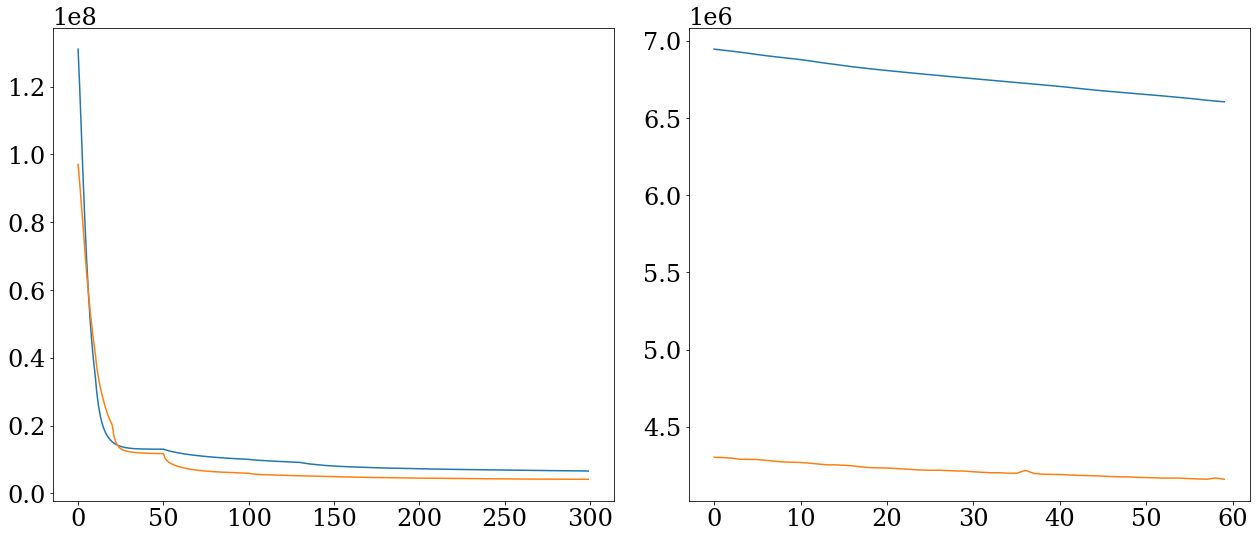

In [29]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

32.222095 31.841854


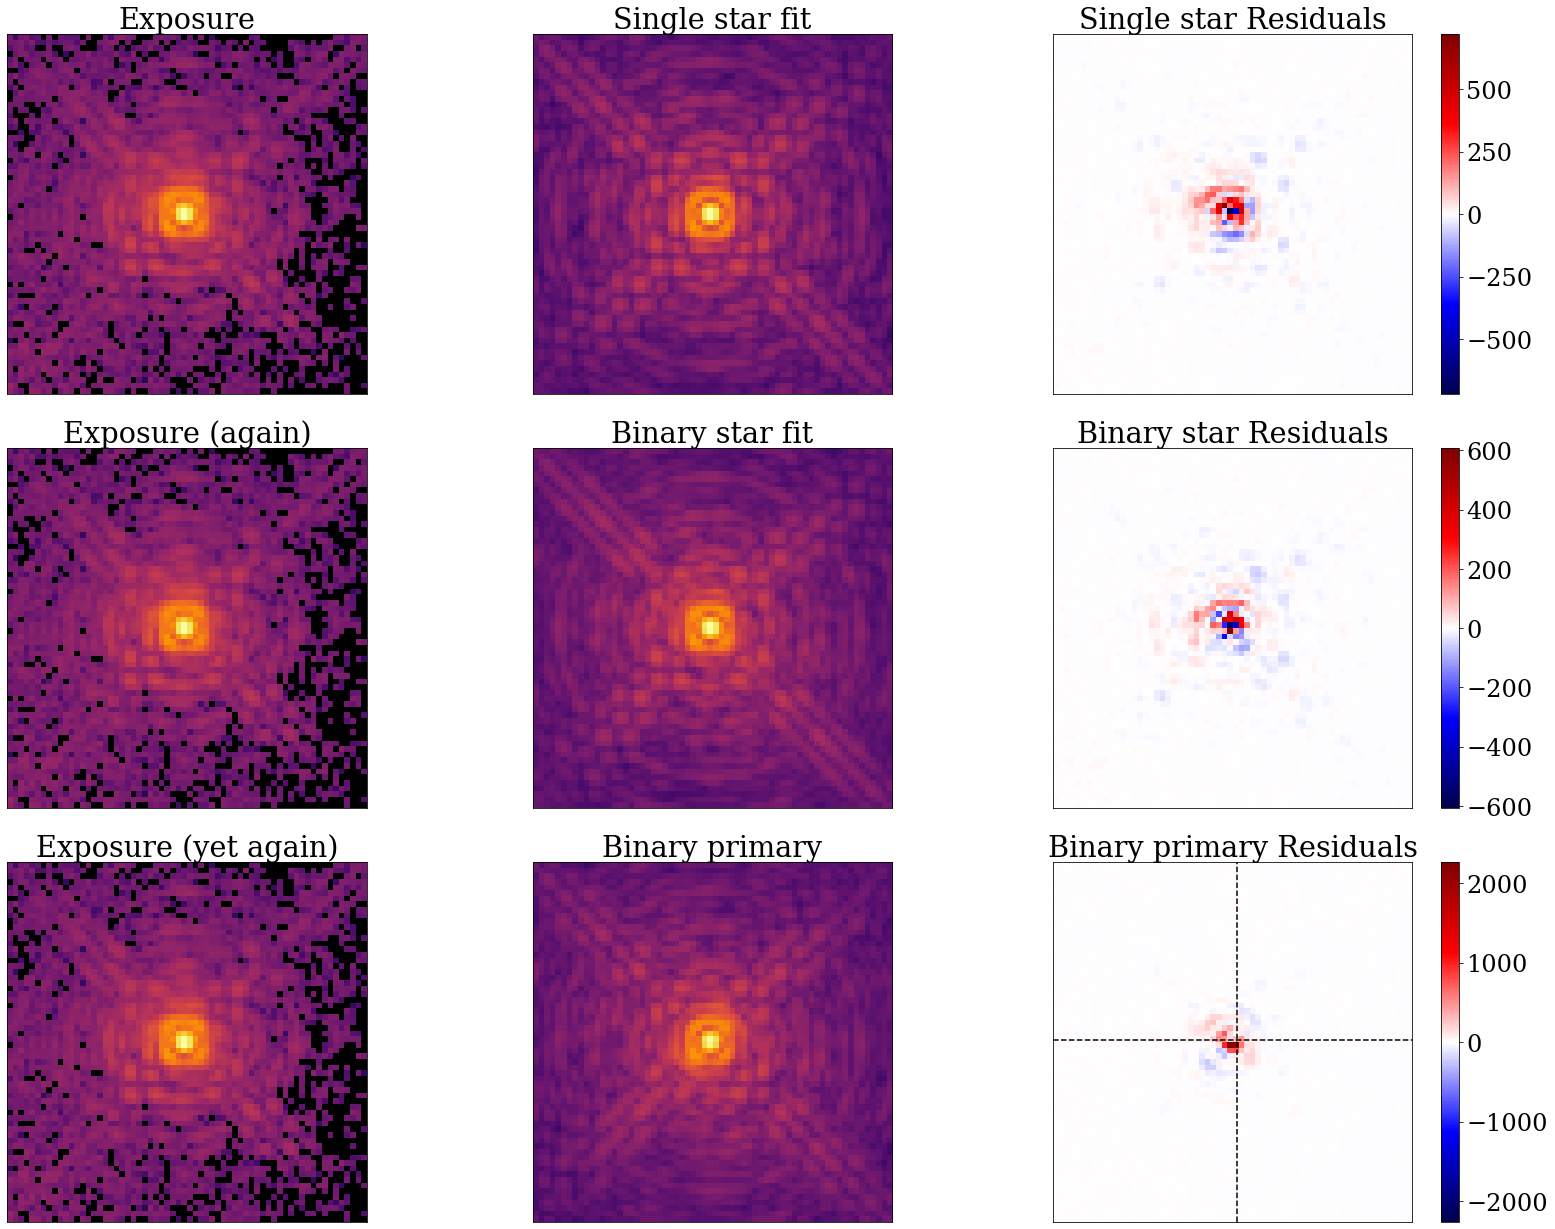

In [39]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))


cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

ind = 2

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposures_s[ind].data**0.125

exposure_s = exposures_s[ind]
exposure_b = exposures_b[ind]

point_frame = exposure_s.fit(point_model, exposure_s)**0.125
binary_frame = exposure_b.fit(binary_model, exposure_b)**0.125

single_resid = (exposure_s.data-exposure_s.fit(point_model, exposure_s))/exposure_s.err
binary_resid = (exposure_b.data-exposure_b.fit(binary_model, exposure_b))/exposure_b.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

#f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))

e_filter = binary_model.filters[exposure_b.filter]

wavels = e_filter[:,0]
weights = e_filter[:,1]

positions = dlu.positions_from_sep(
        binary_model.get(exposure_b.map_param("positions")),
        binary_model.params["separation"],
        binary_model.params["position_angle"]
    )

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels,weights),
    position = positions[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.get(exposure_b.map_param("fluxes")),
        binary_model.get(exposure_b.map_param("contrast")),
    )[1]
)

binary_optics = exp.fit.update_optics(binary_model, exp)


binary_primary_system = dl.Telescope(
    binary_optics,
    #binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure_b.data-binary_primary_system.model())/exposure_b.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(positions[0])/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


8


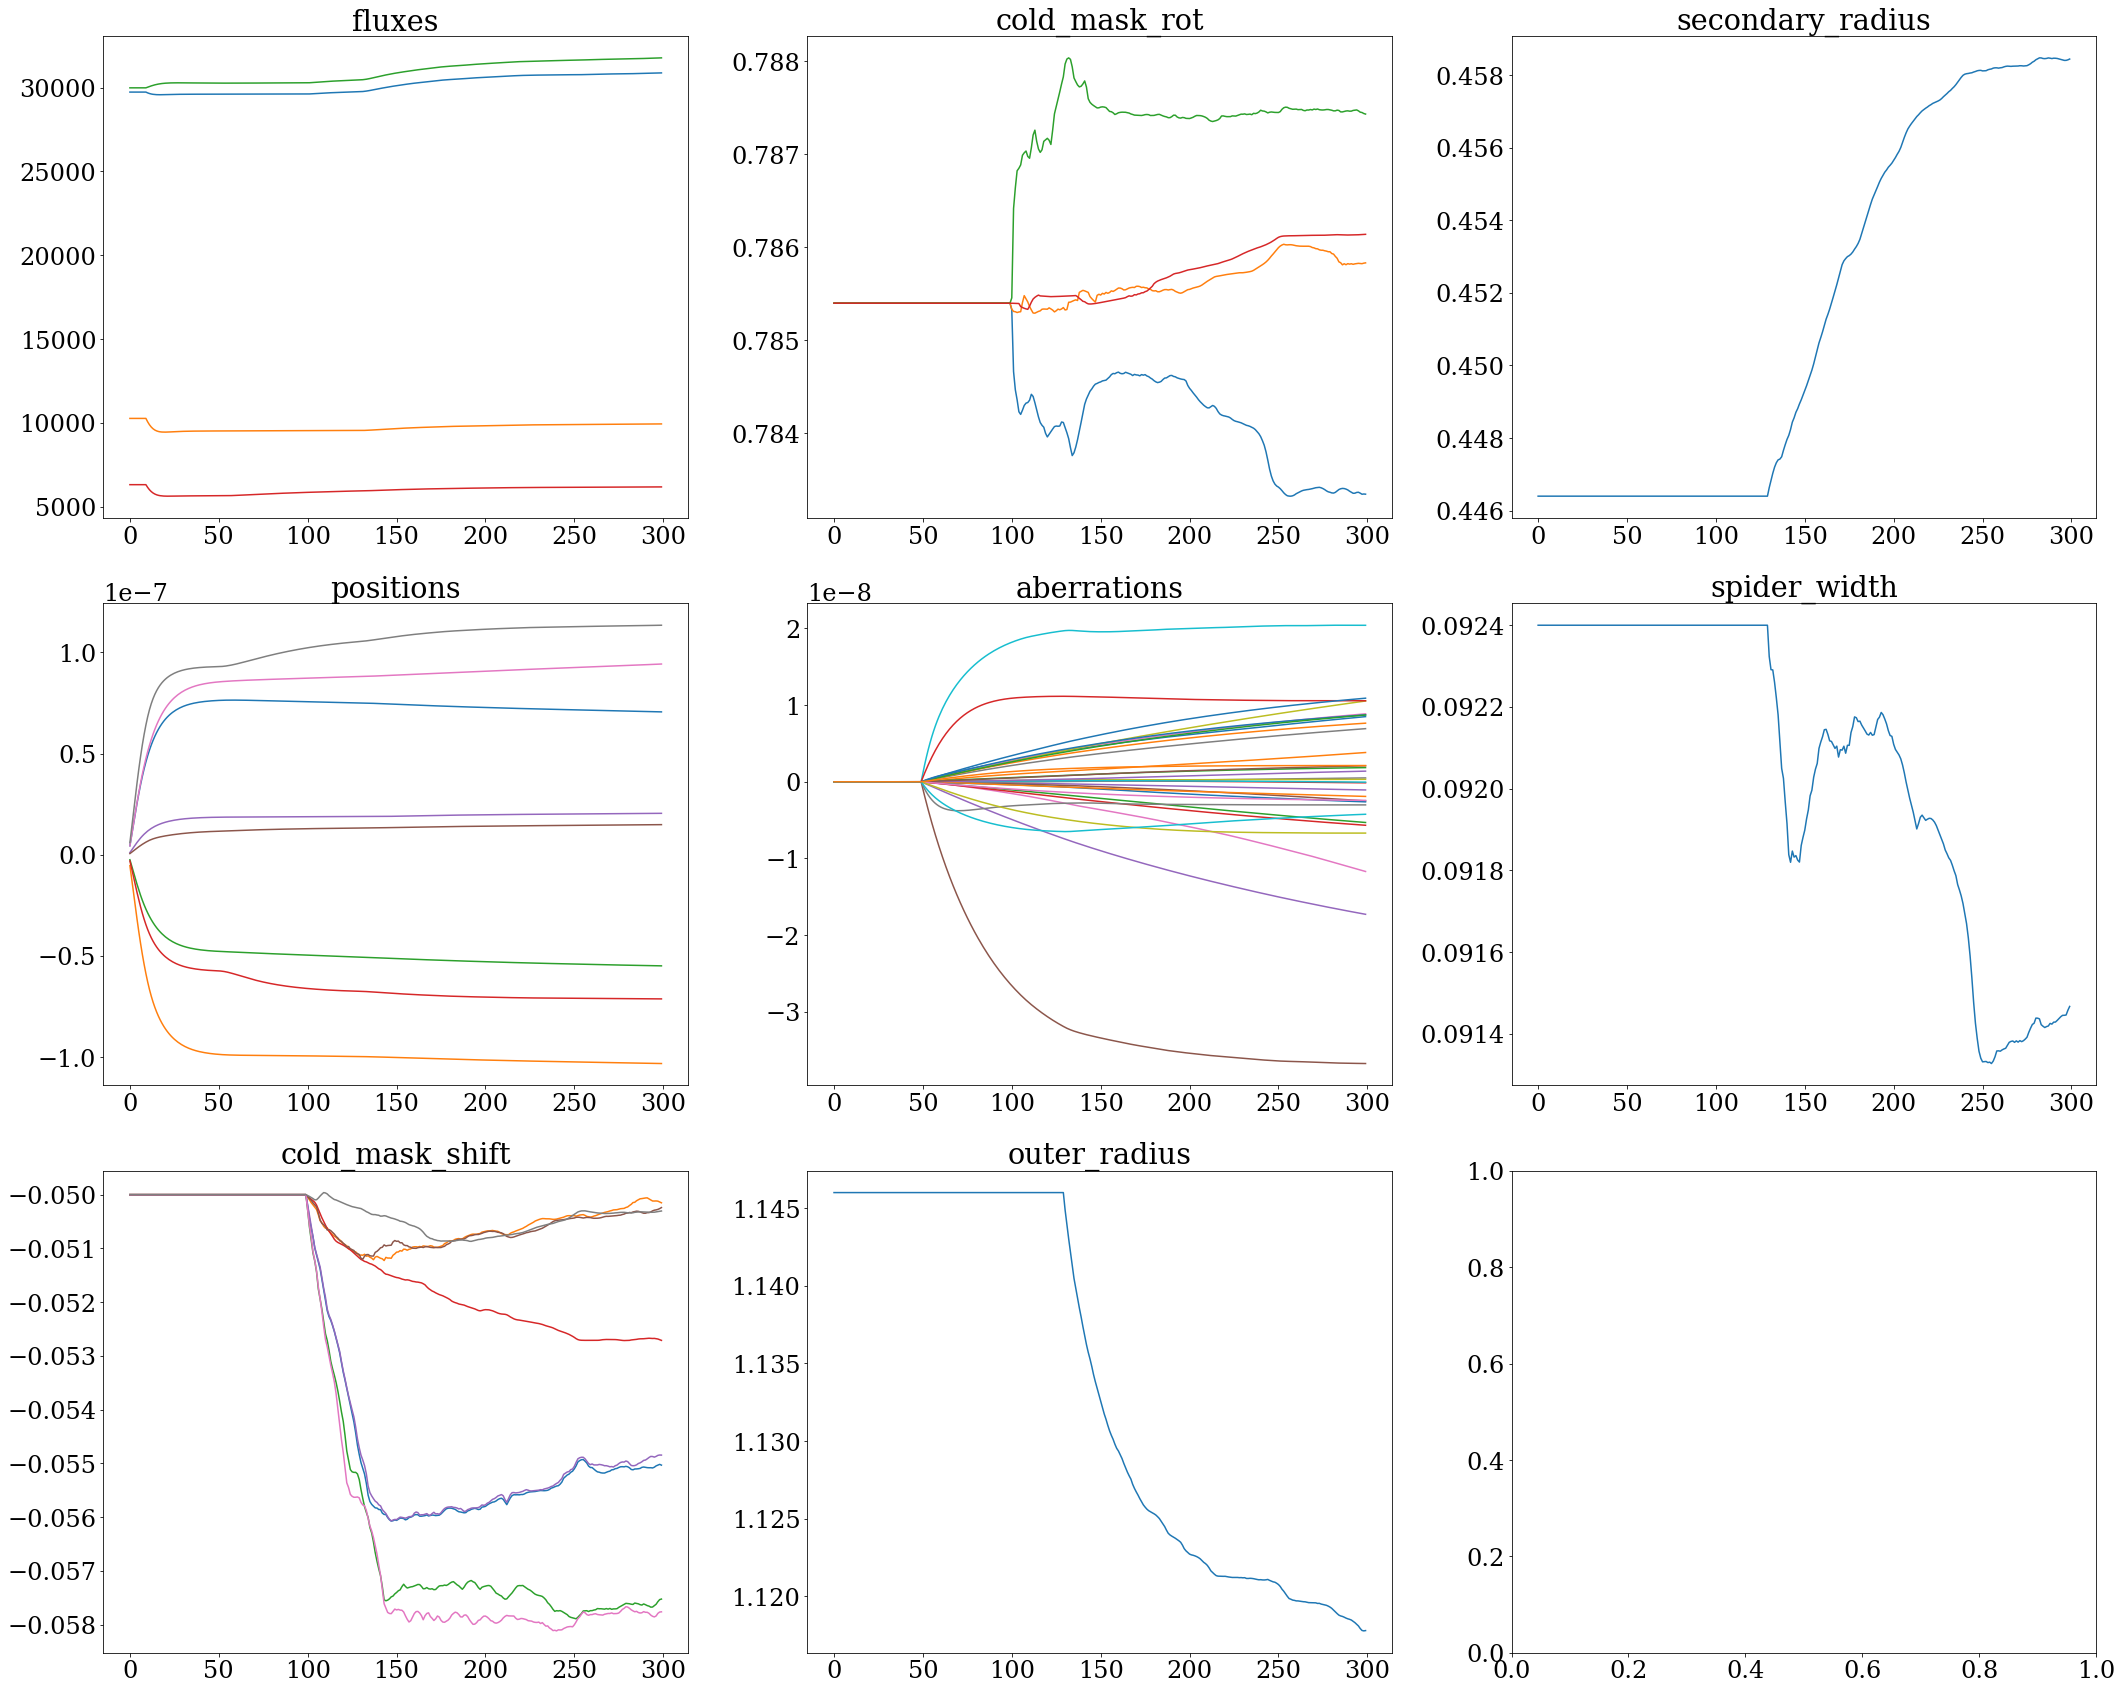

In [31]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_s]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

11


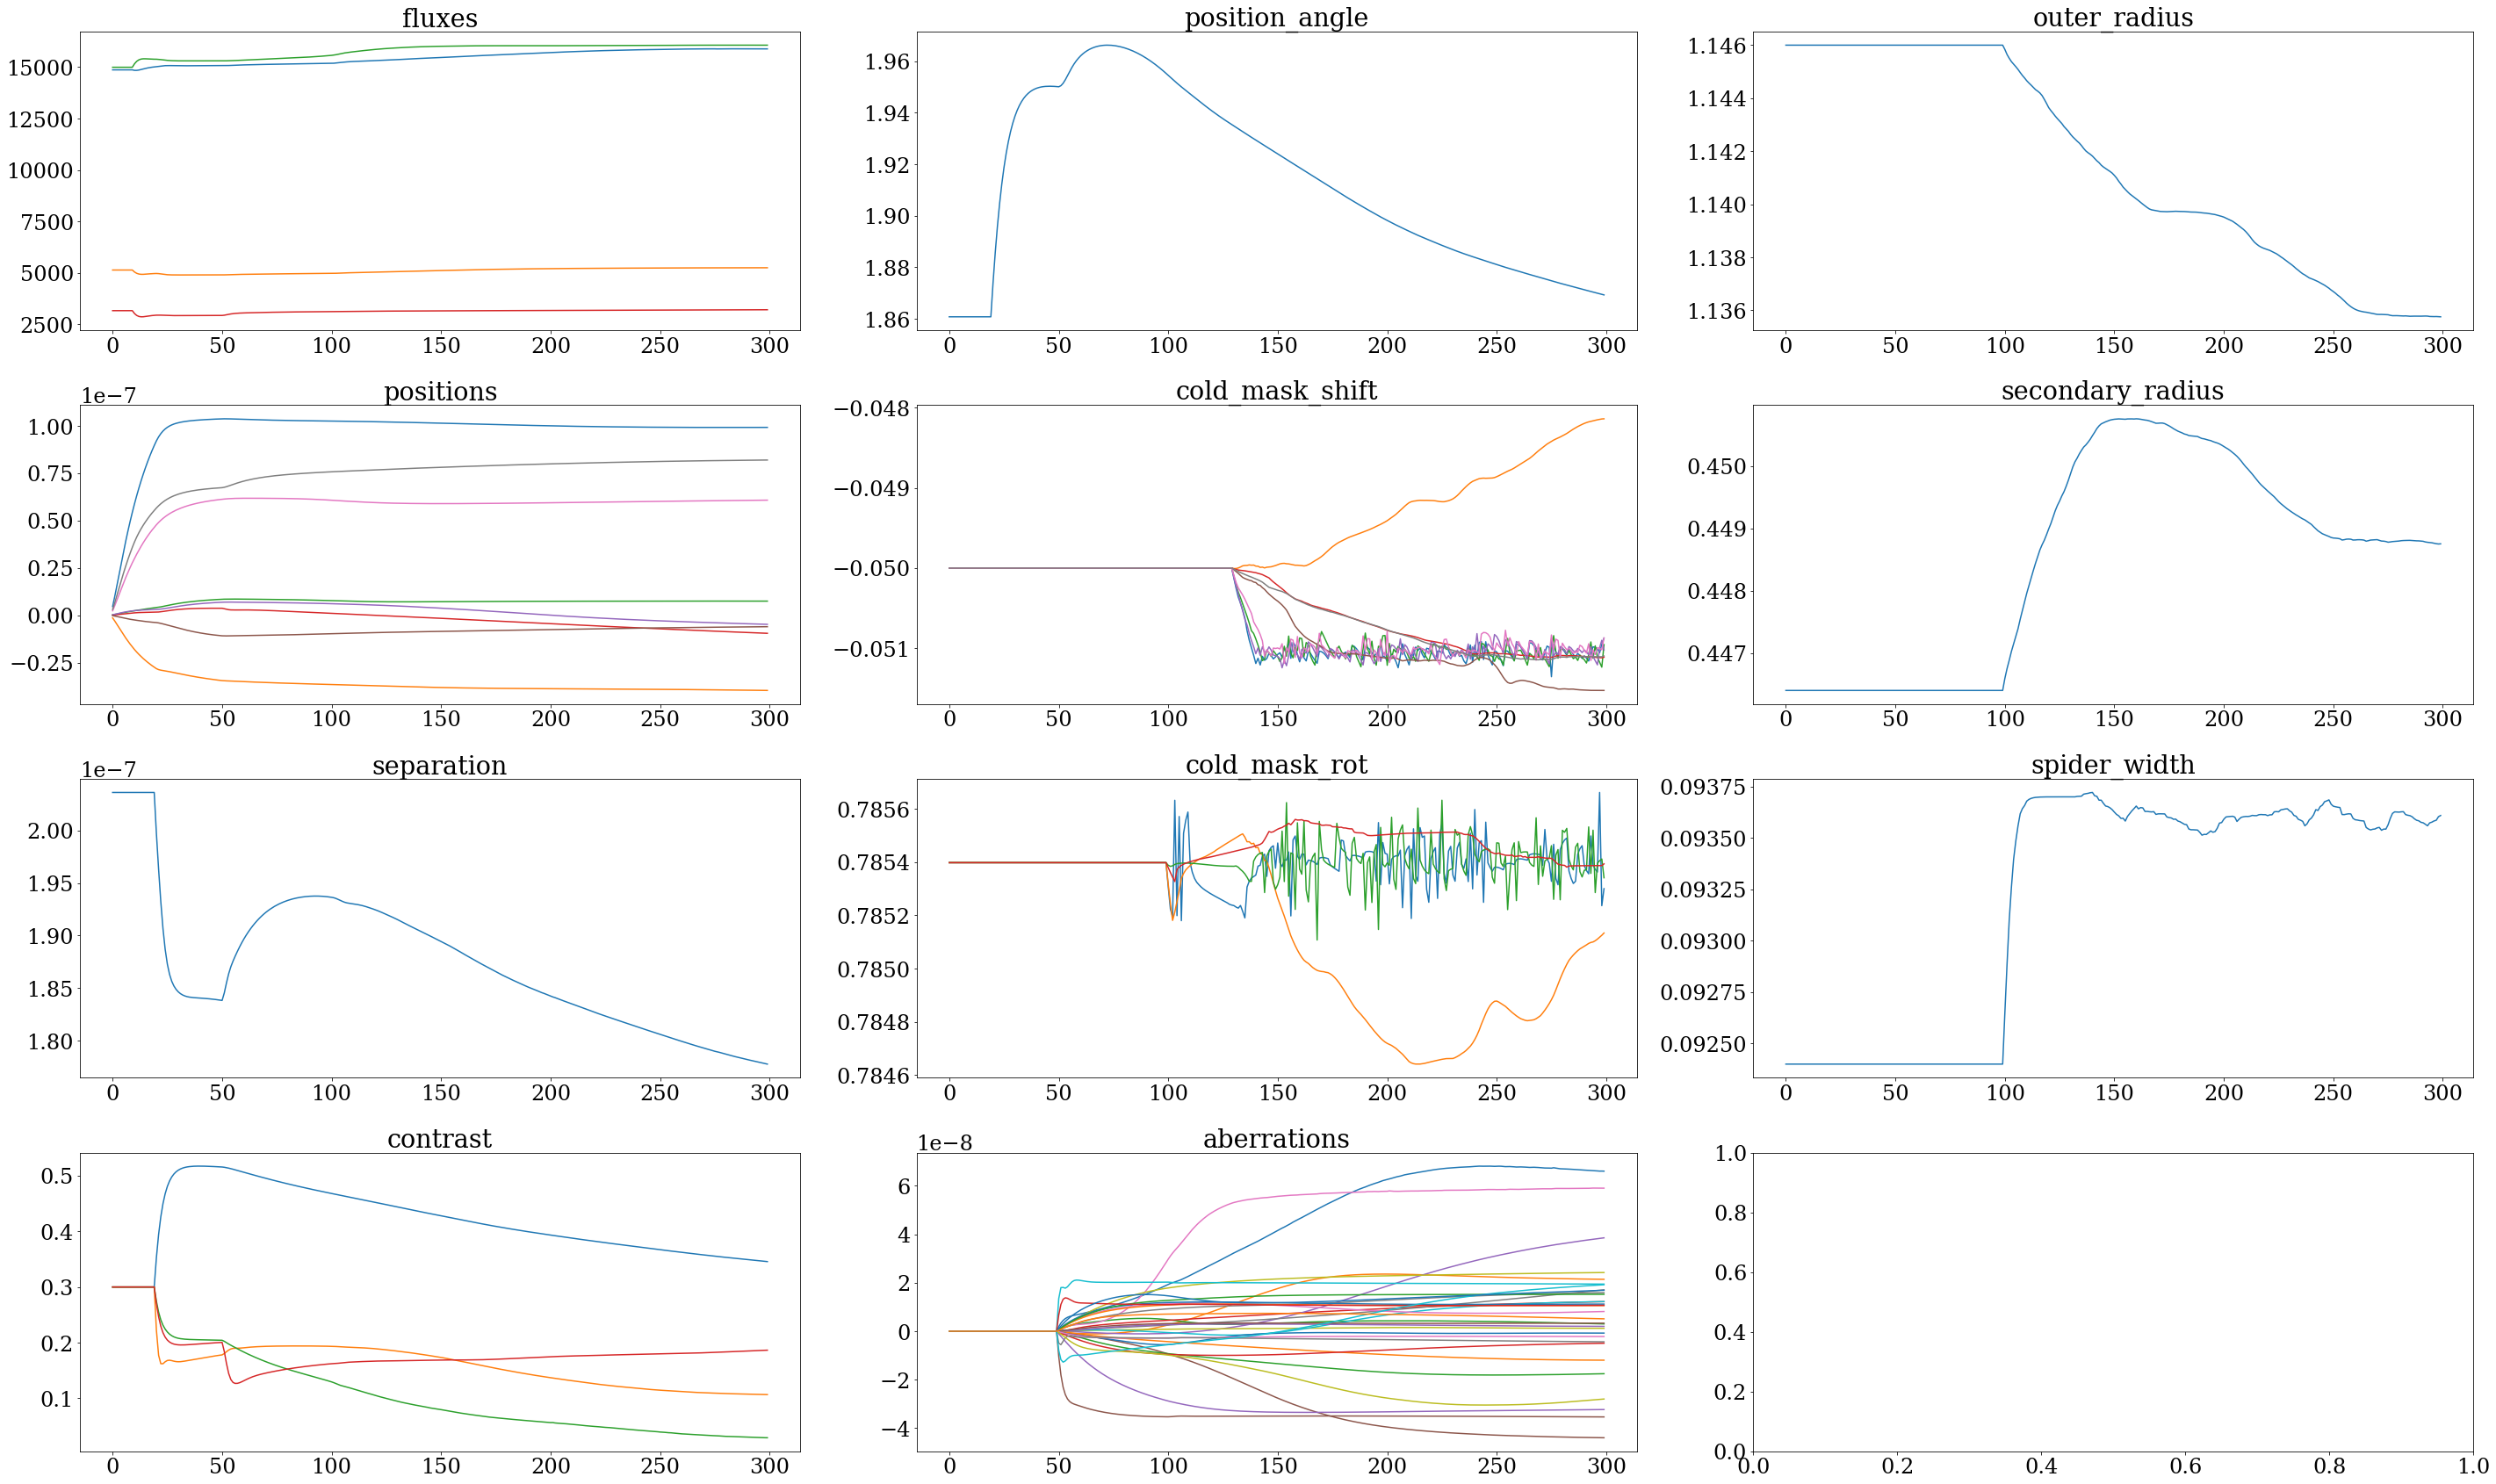

In [32]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_b[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_b]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()

Evidence

In [33]:
#rc = True
#fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc, save=False)

#fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc, save=False)


In [34]:
#fishers_s
#[[numpy.linalg.det(u.astype(np.float64)) for u in v.values()] if type(v)==dict else numpy.linalg.det(v) for v in fishers_s.values()]